## We start off by importing the data

In [37]:
import pandas as pd


csv = "https://raw.githubusercontent.com/ard-data/2020-rki-impf-archive/master/data/9_csv_v2/region_BY.csv"
csv = "vac-data.csv"

df = pd.read_csv(csv, sep=',', index_col=0, parse_dates=True) # it's important to define index and parse_dates

## We'll have a look at the column names

In [38]:
# list(df.columns.values)

### Let's remove columns that don't interest us

In [39]:
uninteresting = ['indikation_alter_dosen', 'indikation_alter_erst', 'indikation_alter_voll',
                 'indikation_beruf_dosen', 'indikation_beruf_erst', 'indikation_beruf_voll',
                 'indikation_medizinisch_dosen', 'indikation_medizinisch_erst', 'indikation_medizinisch_voll',
                'indikation_pflegeheim_dosen', 'indikation_pflegeheim_erst', 'indikation_pflegeheim_voll']

different_vaccines = ['dosen_biontech_kumulativ', 'dosen_erst_biontech_kumulativ', 'dosen_voll_biontech_kumulativ',
                      'dosen_moderna_kumulativ', 'dosen_erst_moderna_kumulativ', 'dosen_voll_moderna_kumulativ',
                      'dosen_astrazeneca_kumulativ', 'dosen_erst_astrazeneca_kumulativ', 'dosen_voll_astrazeneca_kumulativ']

df = df.drop(uninteresting, axis=1)
df = df.drop(different_vaccines, axis=1)
list(df.columns.values)


['publication_date',
 'dosen_kumulativ',
 'personen_erst_kumulativ',
 'personen_voll_kumulativ',
 'dosen_differenz_zum_vortag',
 'dosen_erst_differenz_zum_vortag',
 'dosen_voll_differenz_zum_vortag',
 'impf_quote_dosen',
 'impf_quote_erst',
 'impf_quote_voll',
 'impf_inzidenz_dosen',
 'impf_inzidenz_erst',
 'impf_inzidenz_voll']

### Or actually let's just pick the few columns that interest us

In [40]:
df = df[['publication_date', 'dosen_kumulativ', 'impf_inzidenz_dosen']]

## Let's fix the data

### We'll first fill missing rows, Saturdays seem to be missing!

In [41]:
idx = pd.date_range(df.index.min(), df.index.max())

df = df.reindex(idx, method='ffill')

#fill_value=0 
# convert column "a" to int64 dtype and "b" to complex type
# df = df.astype({'dosen_kumulativ': int})

In [42]:
# df['dosen_kumulativ'] = df['dosen_kumulativ'].fillna(method='ffill')
# df['impf_inzidenz_dosen'] = df['impf_inzidenz_dosen'].fillna(0)
# df.head(5)

### Let's fix errors in the data. There are two spikes, that just seem out of place

In [43]:
df.dosen_kumulativ = df.dosen_kumulativ.replace(384311, 343668)
df.dosen_kumulativ = df.dosen_kumulativ.replace(1150129, 1186228)
# df.dosen_kumulativ.replace(343668, 384311)

# df.at[29, 'dosen_kumulativ'] = 343668
# df.at['2020-03-03', 'dosen_kumulativ'] = 1186228


## Let's add some new useful columns

### New column Differenz in total doses

In [44]:
df['dosen_kumulativ_differenz_zum_vortag'] = df.dosen_kumulativ - df.dosen_kumulativ.shift(1)
df['dosen_kumulativ_differenz_zum_vortag'] = df['dosen_kumulativ_differenz_zum_vortag'].fillna(0)
df = df.astype({'dosen_kumulativ_differenz_zum_vortag': 'int64'})

### New column: Day of the week

In [45]:
def week_day_string(weekday):
    if weekday == 0:
        return 'Mon'
    elif weekday == 1:
        return 'Tue'
    elif weekday == 2:
        return 'Wed'
    elif weekday == 3:
        return 'Thu'
    elif weekday == 4:
        return 'Fri'
    elif weekday == 5:
        return 'Sat'
    elif weekday == 6:
        return 'Sun'
    else:
        return 'other'

def day_type(weekday):
    if weekday == 5:
        return 'saturday'
    elif weekday == 6:
        return 'sunday'
    else:
        return 'business_day'




df.index = df.index.to_series()
df['weekday'] = df.index.dayofweek
df['is_weekend'] = df.apply(lambda x: day_type(x['weekday']), axis=1)
df['weekday'] = df.apply(lambda x: week_day_string(x['weekday']), axis=1)

## Let's take a look

In [46]:
# df.index = df.index.to_series()
df.tail(14)

,publication_date,dosen_kumulativ,impf_inzidenz_dosen,dosen_kumulativ_differenz_zum_vortag,weekday,is_weekend
2021-03-08,2021-03-09 08:00,1370922,104.453293,38087,Mon,business_day
2021-03-09,2021-03-10 08:00,1410941,107.502421,40019,Tue,business_day
2021-03-10,2021-03-11 08:00,1454715,110.837650,43774,Wed,business_day
2021-03-11,2021-03-12 08:00,1501539,114.405264,46824,Thu,business_day
2021-03-12,2021-03-13 08:00,1548393,117.975164,46854,Fri,business_day
2021-03-13,2021-03-13 08:00,1548393,117.975164,0,Sat,saturday
2021-03-14,2021-03-15 08:00,1621834,123.570781,73441,Sun,sunday
2021-03-15,2021-03-16 08:00,1663320,126.731682,41486,Mon,business_day
2021-03-16,2021-03-17 08:00,1693303,129.016147,29983,Tue,business_day
2021-03-17,2021-03-18 08:00,1724990,131.430443,31687,Wed,business_day


In [47]:
current_official_doses = df.tail(1)['dosen_kumulativ']
current_official_doses.values[0]

1843439

<AxesSubplot:title={'center':'Impfungen Bayern'}>

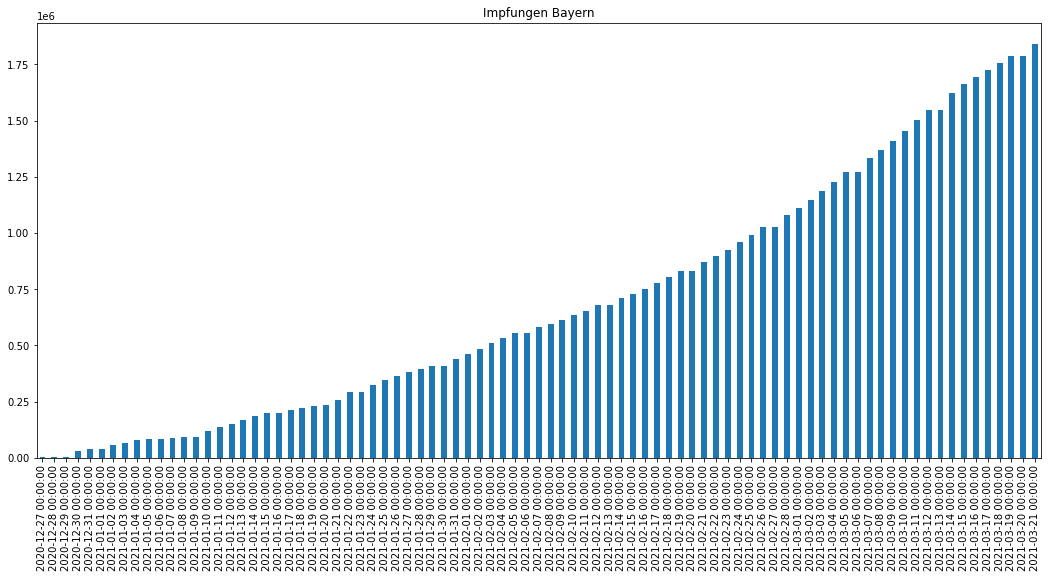

In [48]:
df['dosen_kumulativ'].plot.bar(figsize=(18,8), title='Impfungen Bayern')


In [49]:
print(df['dosen_kumulativ_differenz_zum_vortag'].max())
print(df['dosen_kumulativ_differenz_zum_vortag'].min())

73441
0


In [50]:
df.tail(3)['dosen_kumulativ_differenz_zum_vortag'].values.mean()

28977.666666666668

<AxesSubplot:title={'center':'Impfdosen differenz zum Vortag - Bayern '}>

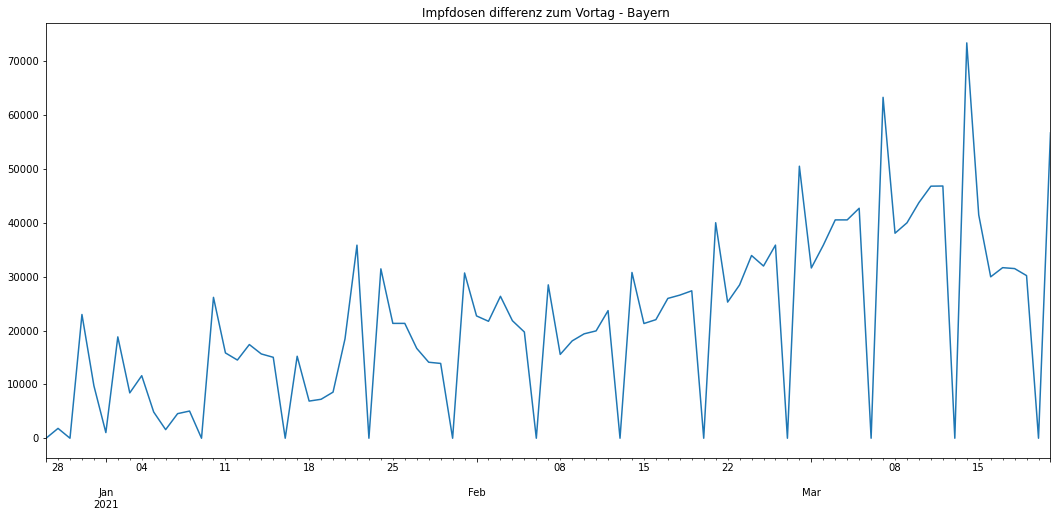

In [51]:
import matplotlib.pyplot
df['dosen_kumulativ_differenz_zum_vortag'].plot.line(figsize=(18,8), title='Impfdosen differenz zum Vortag - Bayern ')


In [52]:
df.
df.groupby(df.index / 3).mean()

TypeError: cannot perform __truediv__ with this index type: DatetimeArray